In [1]:
from torch.utils.data import DataLoader 
import torch
import matplotlib.pyplot as plt
from pyscf import gto, dft, scf 
from kspies import wy, zmp
from dpyscfl.scf import *
from dpyscfl.net import *
from dpyscfl.utils import *
import os, shutil, copy
from ase import Atoms
from ase.units import Bohr, Hartree
import pickle

from ase.io import read, write
from torchviz import make_dot
import pylibnxc
def freeze_net(nn):
    for i in nn.parameters():
        i.requires_grad = False
def unfreeze_net(nn):
    for i in nn.parameters():
        i.requires_grad = True
def freeze_append_xc(model):
    freeze_net(model.xc)
    chil = [i for i in model.xc.children() if isinstance(i, torch.nn.ModuleList)][0]
    xl = [i for i in chil[0].net.children()]
    cl = [i for i in chil[1].net.children()]
    xout = xl.pop()
    cout = cl.pop()
    #duplicate last layer and GELU
    xl += xl[-2:]
    cl += cl[-2:]
    #set last layer as unfrozen
    for p in xl[-2].parameters():
        p.requires_grad = True
    for p in cl[-2].parameters():
        p.requires_grad = True
    xl.append(xout)
    cl.append(cout)
    chil[0].net = torch.nn.Sequential(*xl)
    chil[1].net = torch.nn.Sequential(*cl)

def eval_xc(xc_code, rho, spin=0, relativity=0, deriv=1, verbose=None):
    """ Evaluation for grid-based models (not atomic)
        See pyscf documentation of eval_xc
    """
    inp = {}
    if spin == 0:
        if rho.ndim == 1:
            rho = rho.reshape(1, -1)
        inp['rho'] = rho[0]
        if len(rho) > 1:
            dx, dy, dz = rho[1:4]
            gamma = (dx**2 + dy**2 + dz**2)
            inp['sigma'] = gamma
        if len(rho) > 4:
            inp['lapl'] = rho[4]
            inp['tau'] = rho[5]
    else:
        rho_a, rho_b = rho
        if rho_a.ndim == 1:
            rho_a = rho_a.reshape(1, -1)
            rho_b = rho_b.reshape(1, -1)
        inp['rho'] = np.stack([rho_a[0], rho_b[0]])
        if len(rho_a) > 1:
            dxa, dya, dza = rho_a[1:4]
            dxb, dyb, dzb = rho_b[1:4]
            gamma_a = (dxa**2 + dya**2 + dza**2)  #compute contracted gradients
            gamma_b = (dxb**2 + dyb**2 + dzb**2)
            gamma_ab = (dxb * dxa + dyb * dya + dzb * dza)
            inp['sigma'] = np.stack([gamma_a, gamma_ab, gamma_b])
        if len(rho_a) > 4:
            inp['lapl'] = np.stack([rho_a[4], rho_b[4]])
            inp['tau'] = np.stack([rho_a[5], rho_b[5]])

    parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(xc_code)
    total_output = {'v' + key: 0.0 for key in inp}
    total_output['zk'] = 0
    #print(parsed_xc)
    for code, factor in parsed_xc[1]:
        model = pylibnxc.LibNXCFunctional(xc_code, kind='grid')
        output = model.compute(inp)
        for key in output:
            if output[key] is not None:
                total_output[key] += output[key] * factor

    exc, vlapl, vtau, vrho, vsigma = [total_output.get(key,None)\
      for key in ['zk','vlapl','vtau','vrho','vsigma']]

    vxc = (vrho, vsigma, vlapl, vtau)
    fxc = None  # 2nd order functional derivative
    kxc = None  # 3rd order functional derivative
    return exc, vxc, fxc, kxc

def KS(mol, method, model_path='', nxc_kind='grid', **kwargs):
    """ Wrapper for the pyscf RKS and UKS class
    that uses a libnxc functionals
    """
    #hyb = kwargs.get('hyb', 0)
    mf = method(mol, **kwargs)
    if model_path != '':
        if nxc_kind.lower() == 'atomic':
            model = get_nxc_adapter('pyscf', model_path)
            mf.get_veff = veff_mod_atomic(mf, model)
        elif nxc_kind.lower() == 'grid':
            parsed_xc = pylibnxc.pyscf.utils.parse_xc_code(model_path)
            dft.libxc.define_xc_(mf._numint,
                                 eval_xc,
                                 pylibnxc.pyscf.utils.find_max_level(parsed_xc),
                                 hyb=parsed_xc[0][0])
            mf.xc = model_path
        else:
            raise ValueError(
                "{} not a valid nxc_kind. Valid options are 'atomic' or 'grid'"
                .format(nxc_kind))
    return mf


In [3]:
ref = read('/home/awills/Documents/Research/swxcd/seawulf/g2_97_3/results.traj', ':')
xcdp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2'
xcdfp = '/home/awills/Documents/Research/swxcd/eval/xcdiff_frac/g2_97/preds'
RFP = '/home/awills/Documents/Research/swxcd/eval/rxnfrac/g2_97/preds'
FRP = '/home/awills/Documents/Research/swxcd/eval/fa_rxnfrac/g2_97/preds'
FR1P = '/home/awills/Documents/Research/swxcd/eval/fa1_rxnfrac/g2_97/preds'
xcdcp = '/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_3'
xcdsf = '/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/g2_97/preds'
#paths = [xcdp, xcdfp, RFP, FRP, FR1P, xcdcp]
paths = [xcdp, xcdsf]
es = {p:[] for p in paths}
ref_es = [at.calc.results['energy']/Hartree for at in ref]
for idx,atom in enumerate(ref):
    pckl = '{}_{}.pckl'.format(idx, atom.symbols)
    for key in list(es.keys()):
        if idx == 0:
            print(key)
        with open(key+'/{}'.format(pckl), 'rb') as f:
            e = pickle.load(f)
        es[key].append(e['E'])

n_atoms = [len(at.positions) for at in ref]
def mse(ref_es, pred_es, n_atoms):
    err = []
    for idx in range(len(ref_es)):
        ref = ref_es[idx]
        pred = pred_es[idx]
        nat = n_atoms[idx]
        err.append((ref-pred)**2)
    mse = np.mean(err)
    std = np.std(err)
    return ([np.sqrt(ierr) for ierr in err], mse, std)

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/g2_97/preds


In [4]:
errd = {key: mse(ref_es, val, n_atoms) for key,val in es.items()}
labels = {xcdp: 'XCDiff',
         xcdsf: 'XCDiff+F (Full Net)'}

/home/awills/Documents/Research/swxcd/eval/xcdiff/g2_97/preds_2 0.003096511376351026
/home/awills/Documents/Research/swxcd/eval/xcdsymfrac/g2_97/preds 0.5076436874232311


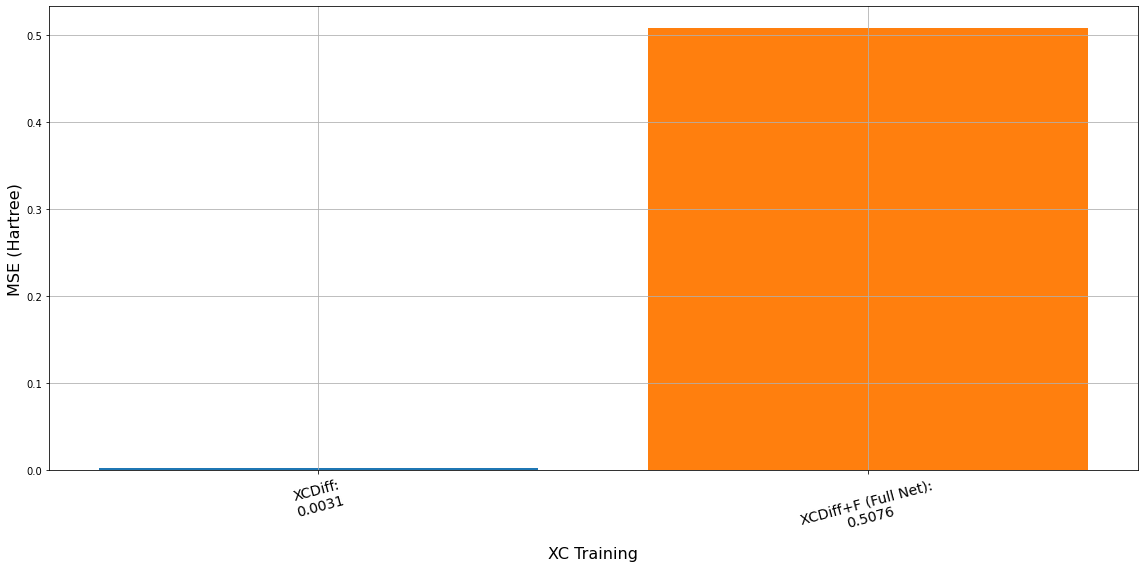

In [5]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
count = 1
xtlabs = []
ax.grid()
for k,v in errd.items():
    if k == xcdfp:
        continue
    print(k, v[1])
    lab = labels[k]+':\n{:3.4f}'.format(v[1])
    ax.bar(count, v[1], label=lab)
    xtlabs.append(lab)
    count += 1
ax.set_xticks(np.arange(1, count))
ax.set_xticklabels(xtlabs, fontsize=14, rotation=15)
ax.set_ylabel("MSE (Hartree)", fontsize=16)
ax.set_xlabel("XC Training", fontsize=16)
plt.tight_layout()

<BarContainer object of 148 artists>

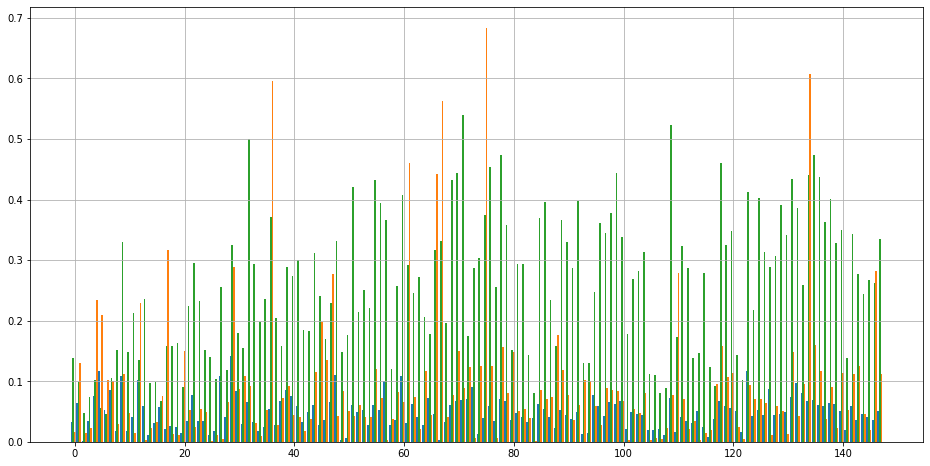

In [5]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
ax.grid()
def gen_xs_bar(*args, **kwargs):
    midsep = kwargs.get('midsep', 1)
    width = kwargs.get('width', midsep/(len(args)+2))
    xs = []
    start = -len(args)//2
    for iarg in range(len(args)):
        arg = args[iarg]
        argxs = []
        for igroup in range(len(arg)):
            argxs.append(igroup*midsep+start*width)
        start += 1
        xs.append(argxs)
    return xs
xcdx, xcdfx, xcdfgx = gen_xs_bar(xcderr, xcdferr, xcdfgerr, width=0.3)
ax.bar(xcdx, xcderr, width=0.3)
ax.bar(xcdfgx, xcdfgerr, width=0.3)
ax.bar(xcdfx, xcdferr, width=0.3)